In [157]:
import sys
!{sys.executable} -m pip install --user graphviz
!{sys.executable} -m pip install --user torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 MB 6.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/5e/5d/97afbafd9d584ff1b45fcb354a479a3609bd97f912f8f1f6c563cb1fae21/filelock-3.12.4-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions from https://files.pythonhosted.org/packages/24/21/7d397a4b7934ff4028987914ac1044d3b7d52712f30e2ac7a2ae5bc86dd0/typing_extensions-4.8.0-py3-none-any.whl.metadata
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.12.4-py3-none-any.whl (11 kB)
Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded 

In [184]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

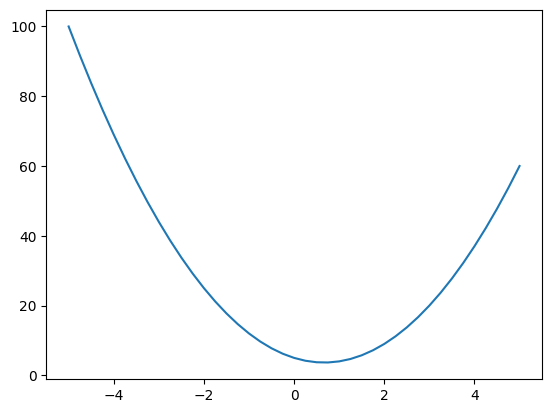

In [4]:
xs = np.arange(-5,5.25,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d) 

4.0


In [7]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b +c 

print ('d1', d1)
print ('d2', d2)
print ('slope', (d2-d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [221]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
        

In [151]:
a = Value (3.0)
a * 2

Value(data=6.0)

In [47]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')

e = a*b;
e.label = 'e'

d = e + c
d.lable = 'd'

f = Value(-2.0, label='f')
L = d*f 
L.label = 'L'


In [48]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [49]:
d._op

'+'

In [111]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

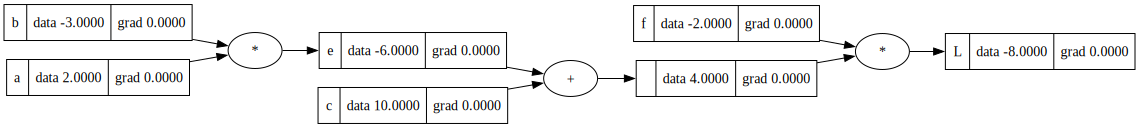

In [51]:
draw_dot(L)

In [52]:
c.grad = -2.0
e.grad = -2.0

In [53]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [54]:
# Chain rule Chain rule Chain rule!
dL/de = -2.0
e = a*b
de/da?  b
dL/da = (dL / de) * (de/da)

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3287587479.py, line 2)

In [55]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.4352


In [56]:
# Backpropogate through a neurons

In [57]:
#Tanh function 

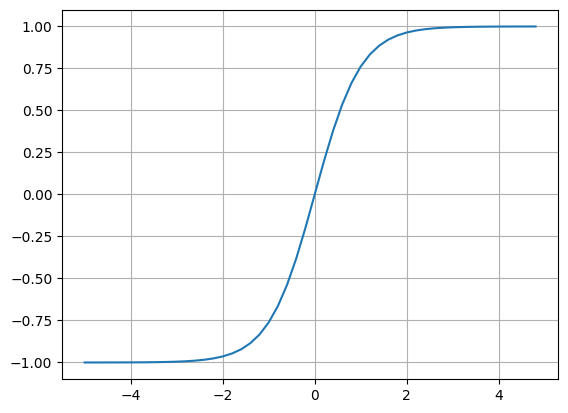

In [58]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [162]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label  = 'w2')

b  = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; label = 'n'

o = n.tanh(); o.label = 'o'

o.grad = 1.0

o.backward()

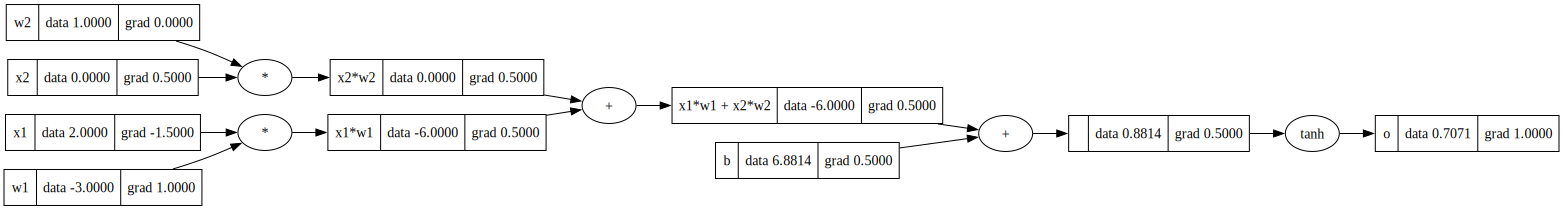

In [163]:
draw_dot(o)

In [ ]:

# topological sort -> https://en.wikipedia.org/wiki/Topological_sorting

In [ ]:
# we have a bug! gradients are accumulating for a multi variable chain rule case so we should be using += 

In [160]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')

print('x2', x2.grad.item())
print('w2', w2.grad.item())

print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [244]:
class Neuron:

    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [245]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])

n(x) 

Value(data=-0.5997326069995506)

In [246]:
n.parameters()

[Value(data=0.18254165034302194),
 Value(data=0.5815952473593284),
 Value(data=-0.6136988147722855),
 Value(data=0.0626571825808031),
 Value(data=-0.049129145977418354),
 Value(data=0.3381412402678665),
 Value(data=-0.09860813352420528),
 Value(data=0.3873827970079209),
 Value(data=-0.431974845194649),
 Value(data=-0.42321790938062454),
 Value(data=0.451670041587523),
 Value(data=-0.13297137986305563),
 Value(data=0.301966768010846),
 Value(data=-0.03697524610762559),
 Value(data=-0.0710552349896103),
 Value(data=0.145137719373708),
 Value(data=0.7300630411821238),
 Value(data=0.8950851189808338),
 Value(data=-0.5300801884263875),
 Value(data=0.8333773652828946),
 Value(data=0.9691638046606477),
 Value(data=0.45902986331034534),
 Value(data=-0.19435729583080197),
 Value(data=-0.6170939207733426),
 Value(data=-0.9715018251501184),
 Value(data=-0.7831913170910862),
 Value(data=-0.8652639695244604),
 Value(data=-0.20582993008233985),
 Value(data=0.047598887762450026),
 Value(data=0.405000

In [247]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired target 

In [250]:
# Create empty lists to store the loss values and step numbers
loss_values = []
steps = []

for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))


    # Backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    # Append the loss and step number to the lists
    loss_values.append(loss.data)
    steps.append(k)

    print(k, loss.data)



0 0.0013636462678752075
1 0.0013566537344926542
2 0.0013497309080421189
3 0.0013428767602094412
4 0.001336090282720369
5 0.001329370486855913
6 0.0013227164029818066
7 0.0013161270800914108
8 0.0013096015853616776
9 0.0013031390037217027
10 0.0012967384374335648
11 0.00129039900568488
12 0.0012841198441928372
13 0.0012779001048192499
14 0.001271738955196279
15 0.0012656355783625631
16 0.0012595891724093158
17 0.0012535989501361003
18 0.001247664138716065
19 0.0012417839793701607


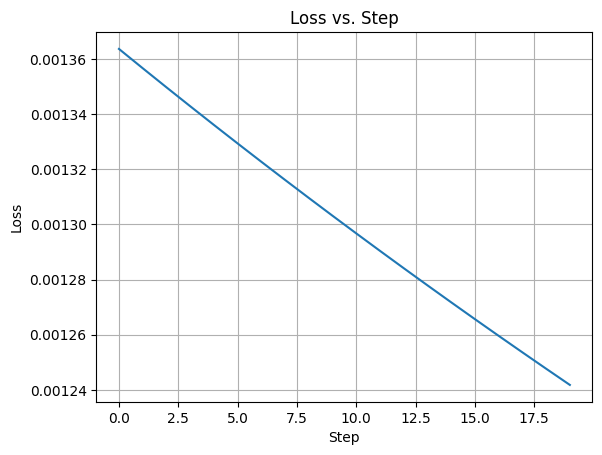

In [251]:
# Plot the loss values
plt.plot(steps, loss_values)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Loss vs. Step")
plt.grid(True)
plt.show()

In [252]:
ypred

[Value(data=0.9866979428508845),
 Value(data=-0.9852612509589073),
 Value(data=-0.977930286452095),
 Value(data=0.9810122071954391)]